In [78]:
import pandas as pd
# openpyxl
import openpyxl
# Załaduj dane z pliku Excel
mandrill_data = pd.read_excel("Dane_3_2_Mandrill.xlsx", sheet_name="GOTOWE DANE")
other_data = pd.read_excel("Dane_3_2_Mandrill.xlsx", sheet_name="GOTOWE INNE")

# Oznacz dane etykietami
mandrill_data['label'] = 'Mandrill'
other_data['label'] = 'inne'

# Połącz dane w jeden zbiór
data = pd.concat([mandrill_data, other_data], ignore_index=True)
data = data[['Post', 'label']]  # Upewnij się, że dane mają kolumny 'Post' i 'label'

data

,Post,label
0,Blog Post: Using Nullmailer and Mandrill for ...,Mandrill
1,Blog Post: Configuring Postfix with Mandrill ...,Mandrill
2,A user reports email delivery issues to spam;...,Mandrill
3,A user switched to Mandrill for email deliver...,Mandrill
4,Positive feedback on Mandrill’s transactional...,Mandrill
...,...,...
297,Exploring the colorful monkey butts of Mandril...,inne
298,"Introduction to Mandrill Maze, a classic PC ga...",inne
299,Recommending Mandrill's 1975 work with a focus...,inne
300,"Mandrill's 1980 release 'Getting In The Mood,'...",inne


In [79]:
from sklearn.model_selection import train_test_split

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    data['Post'], data['label'], test_size=0.2, random_state=42
)


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Przekształć dane tekstowe na wektory numeryczne
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [81]:
from sklearn.naive_bayes import MultinomialNB

# Trening modelu
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)


MultinomialNB()

In [82]:
from sklearn.metrics import classification_report, accuracy_score

# Przewidywanie klas na zbiorze testowym
y_pred = classifier.predict(X_test_tfidf)

# Wyświetl raport klasyfikacji
print(classification_report(y_test, y_pred))
print(f"Dokładność: {accuracy_score(y_test, y_pred):.2f}")


              precision    recall  f1-score   support

    Mandrill       0.94      0.94      0.94        31
        inne       0.93      0.93      0.93        30

    accuracy                           0.93        61
   macro avg       0.93      0.93      0.93        61
weighted avg       0.93      0.93      0.93        61

Dokładność: 0.93


In [83]:
new_posts = [
    "The Mandrill API is great for sending personalized emails!",
    "I saw a Mandrill at the zoo today, it was fascinating!"
]

new_posts_tfidf = vectorizer.transform(new_posts)
predictions = classifier.predict(new_posts_tfidf)

for post, prediction in zip(new_posts, predictions):
    print(f"Post: {post} => Klasyfikacja: {prediction}")


Post: The Mandrill API is great for sending personalized emails! => Klasyfikacja: Mandrill
Post: I saw a Mandrill at the zoo today, it was fascinating! => Klasyfikacja: inne


In [84]:
from sklearn.linear_model import LogisticRegression

# Tworzenie i trening modelu regresji logistycznej
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_tfidf, y_train)



LogisticRegression(max_iter=1000, random_state=42)

In [85]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# Przewidywanie klas za pomocą regresji logistycznej
y_pred_logistic = logistic_model.predict(X_test_tfidf)

# Wyświetlenie raportu klasyfikacji
print("=== Regresja Logistyczna ===")
print(classification_report(y_test, y_pred_logistic))
print(f"Dokładność: {accuracy_score(y_test, y_pred_logistic):.2f}")

# krzywa ROC


=== Regresja Logistyczna ===
              precision    recall  f1-score   support

    Mandrill       0.97      0.90      0.93        31
        inne       0.91      0.97      0.94        30

    accuracy                           0.93        61
   macro avg       0.94      0.93      0.93        61
weighted avg       0.94      0.93      0.93        61

Dokładność: 0.93


In [86]:
print("=== Porównanie ===")
print("Naive Bayes:")
print(f"Dokładność: {accuracy_score(y_test, y_pred):.2f}")
print("\nRegresja Logistyczna:")
print(f"Dokładność: {accuracy_score(y_test, y_pred_logistic):.2f}")


=== Porównanie ===
Naive Bayes:
Dokładność: 0.93

Regresja Logistyczna:
Dokładność: 0.93


In [87]:
# Przewidywanie nowych postów
logistic_predictions = logistic_model.predict(new_posts_tfidf)

for post, prediction in zip(new_posts, logistic_predictions):
    print(f"Post: {post} => Klasyfikacja (Regresja Logistyczna): {prediction}")


Post: The Mandrill API is great for sending personalized emails! => Klasyfikacja (Regresja Logistyczna): Mandrill
Post: I saw a Mandrill at the zoo today, it was fascinating! => Klasyfikacja (Regresja Logistyczna): inne


179        inne
228        inne
111    Mandrill
246        inne
60     Mandrill
         ...   
249        inne
104    Mandrill
299        inne
193        inne
184        inne
Name: label, Length: 61, dtype: object


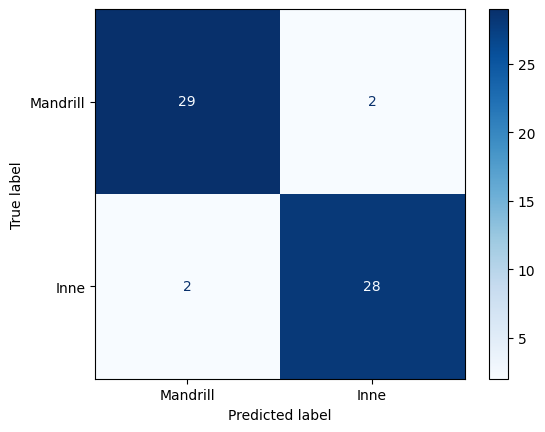

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mandrill", "Inne"])
disp.plot(cmap="Blues")
# krzywa ROC
print(y_test)


AUC po weryfikacji: 0.9774193548387096


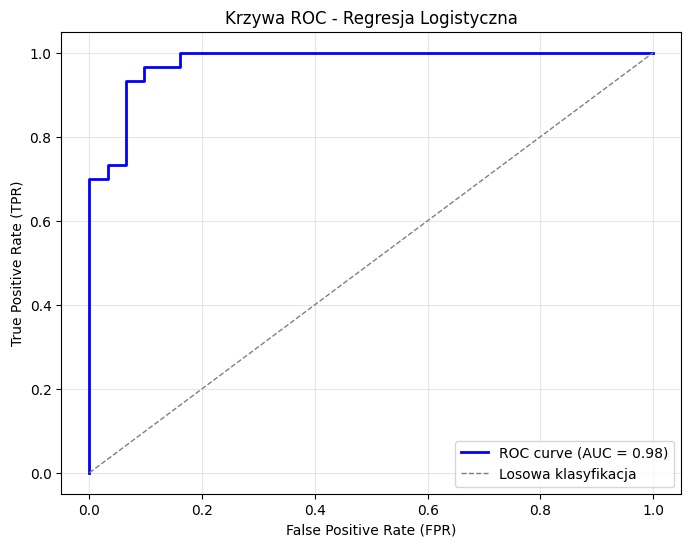

In [89]:
from sklearn.preprocessing import LabelBinarizer

# Przekształcenie etykiet na wartości binarne
binarizer = LabelBinarizer()
y_test_binary = binarizer.fit_transform(y_test).ravel()  # Konwersja y_test na binarne
y_pred_prob_logistic = logistic_model.predict_proba(X_test_tfidf)[:, 1]  # Prawdopodobieństwa klasy pozytywnej

# Obliczenie metryk ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob_logistic)
roc_auc = auc(fpr, tpr)

# Wyświetlenie wyników
print("AUC po weryfikacji:", roc_auc)

# Wizualizacja krzywej ROC
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Losowa klasyfikacja')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Krzywa ROC - Regresja Logistyczna')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
